# Data

To fetch the data we created a repository that housed a script that fetches the data.<br>
The link to the repository can be found here : <br>
https://github.com/sirandreww/operate_first_prometheus_data.git

We have added more information about what data is being fetched and how in that repository.
The main point being that the data we are pulling is:

## How Is Data Fetched?

1. Memory-usage data for each container using this Prometheus query `sum(container_memory_working_set_bytes{name!~".*prometheus.*", image!="", container!="POD", cluster="moc/smaug"}) by (container, pod, namespace, node)`.
   
2. CPU-usage data for each container using this Prometheus query `sum(rate(container_cpu_usage_seconds_total{name!~".*prometheus.*", image!="", container!="POD", cluster="moc/smaug"}[5m])) by (container, pod, namespace, node)`.
   
3. Memory-usage percentage data for each node using this Prometheus query `node_memory_Active_bytes/node_memory_MemTotal_bytes*100`.


## How Is The Data Processed After Fetching?

The data is then merged and turned into json files in that repository. We have created code here that takes those json files and imports them into custom datasets for our project. Let's take a look shall we!

In [1]:
import src.data_set as ds

Getting the dataset for container memory data, for the cointainer bridge-marker.

In [2]:
dataset = ds.get_data_set(
    metric="container_mem",
    application_name="bridge-marker",
    path_to_data="./data/"
)

Now let's plot some samples in the data to get a visual on what we're looking at.

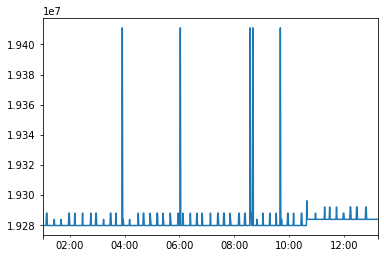

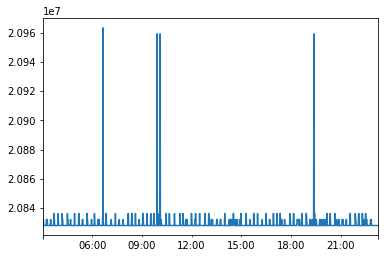

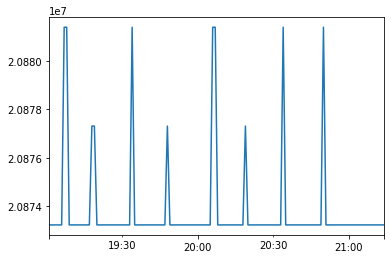

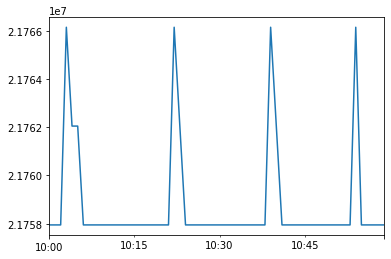

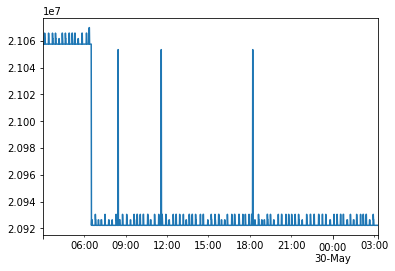

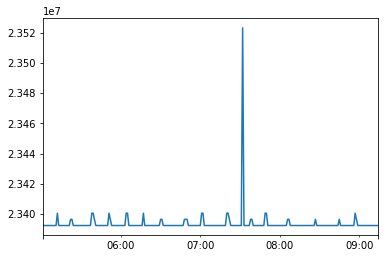

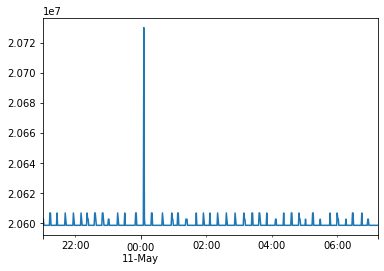

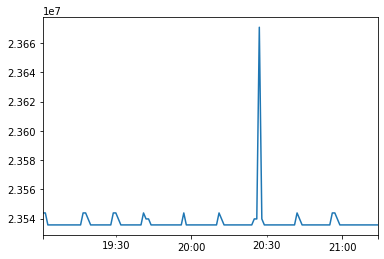

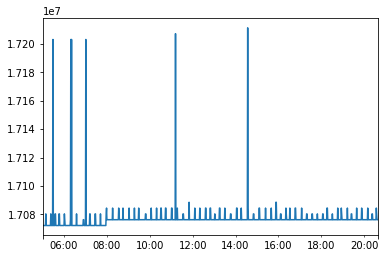

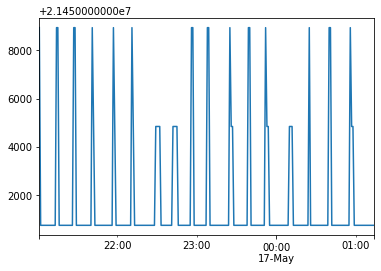

In [3]:
dataset.plot_dataset(number_of_samples=10)

As you can see the data for each application is split to many time series. Each one is continous and without any "interruptions" in the middle.

## What Applications Will We Consider?

As for the applications we're going to be learning on, let's take a look at the applications with the most data for each metric.

First let's take a look at continer cpu usage data:

In [4]:
hist = ds.get_amount_of_data_per_application(
    metric="container_cpu",
    path_to_data="./data/"
)
print(hist[:10])

[('kube-rbac-proxy', 7578821), ('oauth-proxy', 1885203), ('collector', 1602125), ('coredns-monitor', 1564425), ('network-metrics-daemon', 1559549), ('nmstate-handler', 1556575), ('dns-node-resolver', 1554940), ('dns', 1554337), ('node-ca', 1552028), ('kube-multus-additional-cni-plugins', 1549615)]


We'll look at the following applications:
1. kube-rbac-proxy
2. oauth-proxy
3. collector

In [5]:
hist = ds.get_amount_of_data_per_application(
    metric="container_mem",
    path_to_data="./data/"
)
print(hist[:10])

[('kube-rbac-proxy', 7718487), ('cni-plugins', 3142572), ('driver-registrar', 2820695), ('oauth-proxy', 1942223), ('collector', 1701727), ('nmstate-handler', 1587755), ('keepalived', 1587373), ('node-exporter', 1586814), ('coredns', 1586715), ('whereabouts-cni-bincopy', 1586041)]


We'll look at the following applications:
1. kube-rbac-proxy
2. cni-plugins
3. driver-registrar

In [6]:
hist = ds.get_amount_of_data_per_application(
    metric="node_mem",
    path_to_data="./data/"
)
print(hist[:10])

[('moc/smaug', 313820), ('emea/balrog', 72447), ('emea/rick', 54929), ('moc/infra', 25405)]


We'll look at the following nodes:
1. moc/smaug
2. emea/balrog

## How Is Data Pre-Processed?

In [7]:
dataset = ds.get_data_set(
    metric="container_mem",
    application_name="kube-rbac-proxy",
    path_to_data="./data/"
)

Plot the data of this data set:

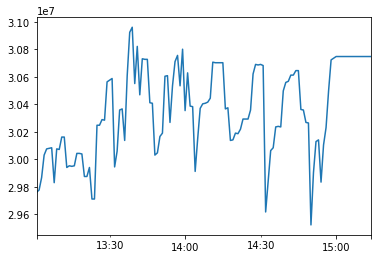

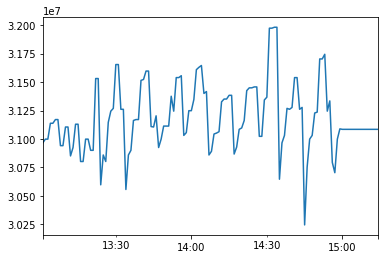

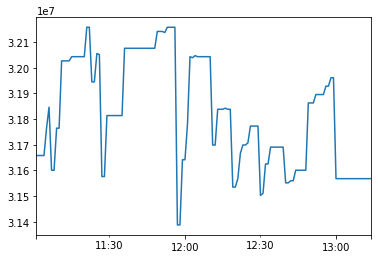

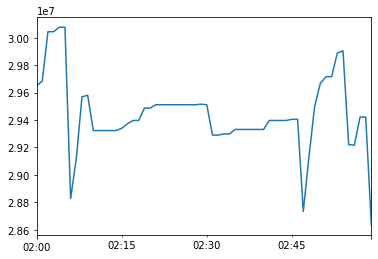

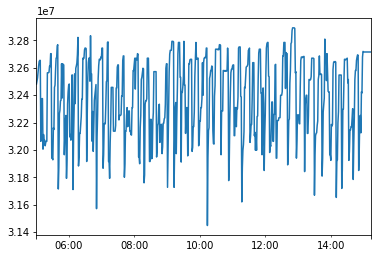

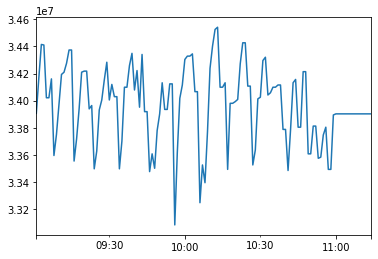

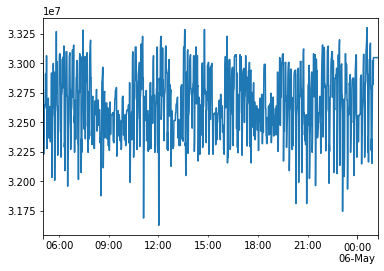

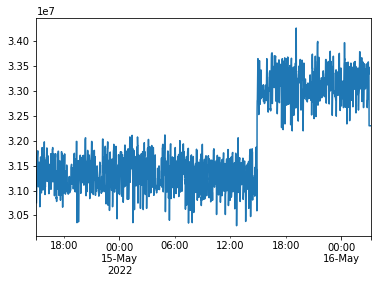

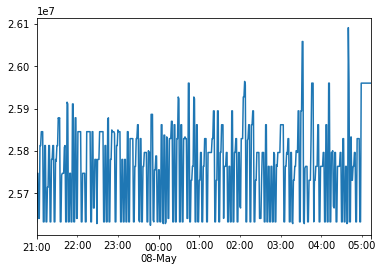

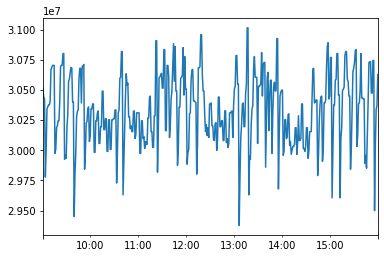

In [8]:
dataset.plot_dataset(number_of_samples=10)

As we can see, we have a sample for each minute, we can further subsample the data to get data that is easier to generalize. Here we change the dataset so it is has samples 5 minutes appart:

In [9]:
dataset.sub_sample_data(sub_sample_rate=5)

Dropping series that are shorter than 10 sample long (less than 5 * 10 minutes long)

In [10]:
print("Data set size before:", len(dataset))
dataset.filter_data_that_is_too_short(data_length_limit=10)
print("Data set size after:", len(dataset))

Data set size before: 14774
Data set size after: 14736


Let's plot again to see how the samples look now.

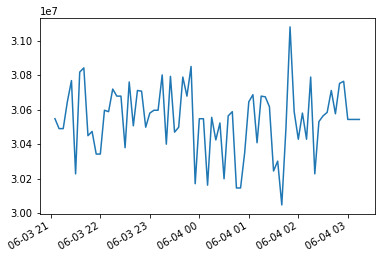

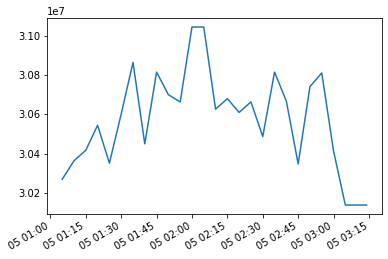

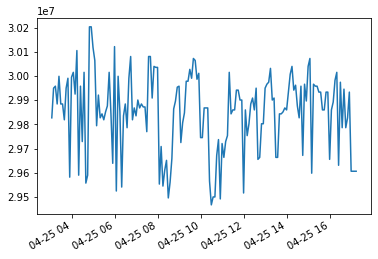

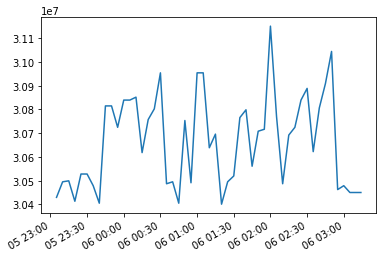

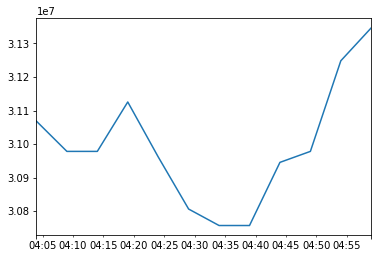

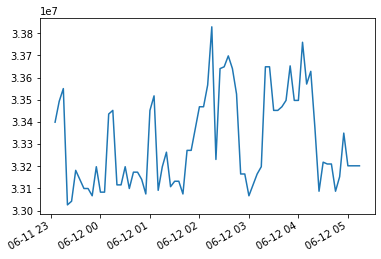

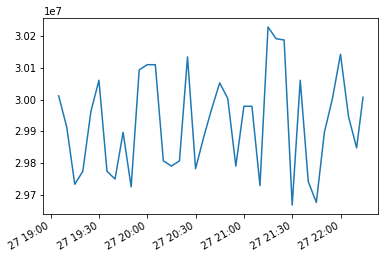

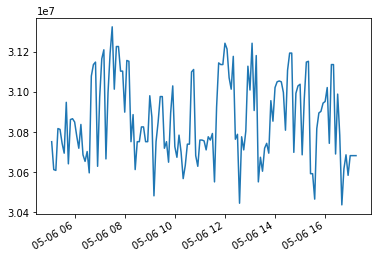

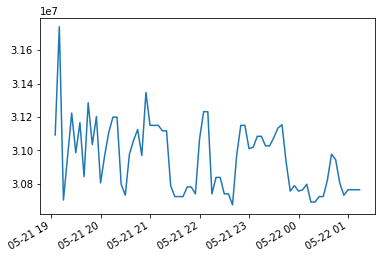

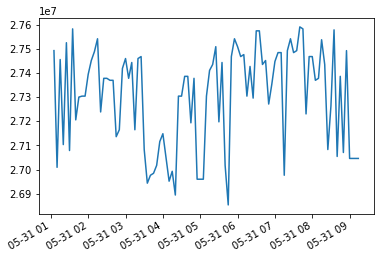

In [11]:
dataset.plot_dataset(number_of_samples=10)

The data is highly variable and is not scaled, let's scale it.

In [12]:
dataset.scale_data()

Let's plot again to see how the samples look now.

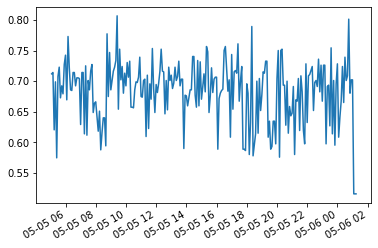

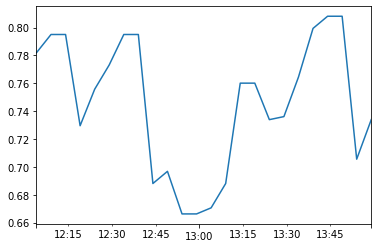

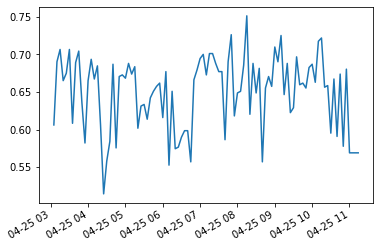

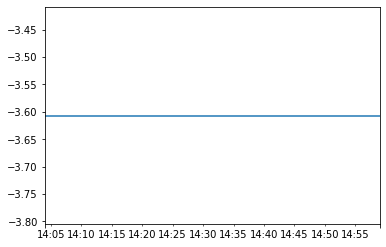

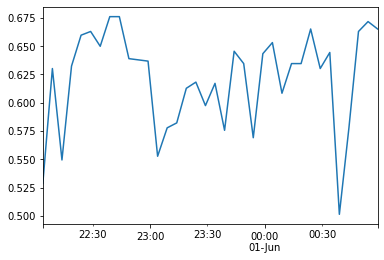

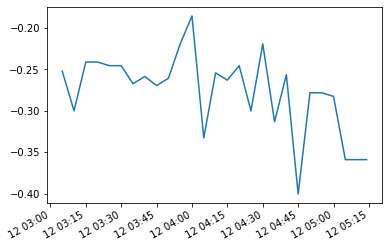

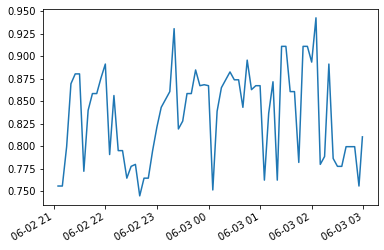

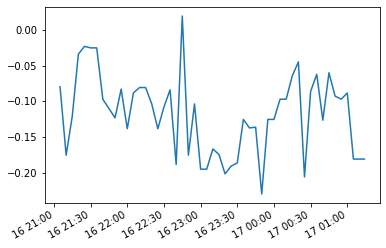

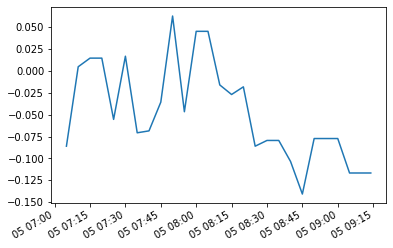

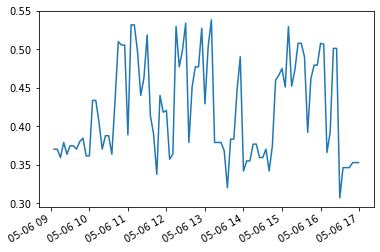

In [13]:
dataset.plot_dataset(number_of_samples=10)

Now we can split the data into train and test.

In [14]:
train, test = dataset.split_to_train_and_test(test_percentage=0.2)
print(f"Amount of train data is {len(train)}")
print(f"Amount of test data is {len(test)}")

Amount of train data is 11789
Amount of test data is 2947


This is the preprocessing that is done to the data each time we use it for trainning.